In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

# Cargamos Dataset y definimos Generator

In [3]:
reduced_dataset_folder = '/home/usuario/repos/Object_Localization/challenge_dataset_v3/'

In [4]:
train_folder = reduced_dataset_folder + '/images/train'
val_folder = reduced_dataset_folder + '/images/val'

In [5]:
annotations_dict_train = np.load(reduced_dataset_folder+'/annotations_train.npy').flat[0]
annotations_dict_val = np.load(reduced_dataset_folder+'/annotations_val.npy').flat[0]

In [6]:
classes = list(annotations_dict_train.keys())
print(classes)

['n02165456', 'n02226429', 'n01644373', 'n02279972', 'n01632458', 'n02256656', 'n01774384', 'n01770393']


In [7]:
from object_detection_helper import GeneratorMultipleOutputs, plot_batch

Using TensorFlow backend.


In [10]:
target_size=(320, 320)

In [11]:
train_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_train, 
                                                            train_folder, 10, classes = classes,
                                                            concat_output = False,
                                                            target_size=target_size
                                                           )
val_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_val, 
                                                              val_folder, 64, classes = classes,
                                                              concat_output = False,
                                                              target_size=target_size
                                                         )

Found 2400 images belonging to 8 classes.
Found 480 images belonging to 8 classes.


# Verificamos los datos Graficando

[0.   0.   0.   0.   0.   0.   1.   0.   0.48 0.44 0.27 0.21]


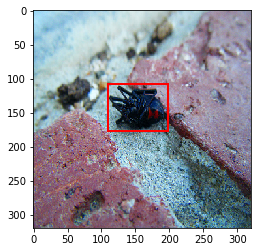

[0.   0.   0.   0.   0.   0.   1.   0.   0.56 0.72 0.28 0.53]


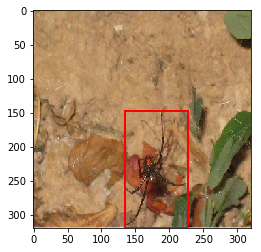

[0.   0.   1.   0.   0.   0.   0.   0.   0.55 0.51 0.21 0.34]


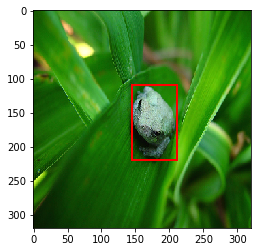

[0.   0.   0.   0.   0.   1.   0.   0.   0.32 0.41 0.62 0.82]


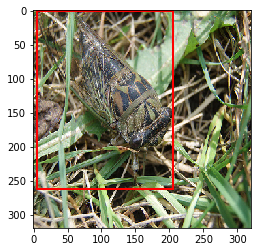

[0.   0.   0.   0.   0.   0.   1.   0.   0.45 0.49 0.91 0.99]


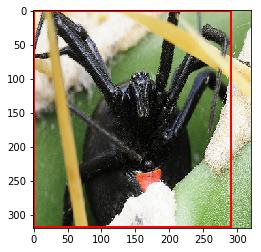

[1.   0.   0.   0.   0.   0.   0.   0.   0.44 0.5  0.24 0.26]


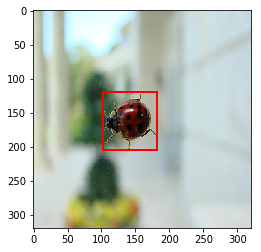

[0.   0.   0.   0.   1.   0.   0.   0.   0.52 0.52 0.82 0.54]


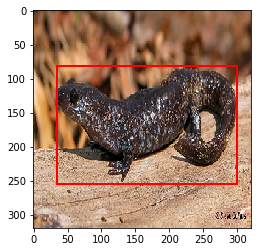

[0.   0.   0.   0.   0.   1.   0.   0.   0.49 0.49 0.47 0.83]


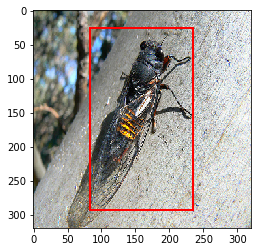

[0.   0.   0.   0.   1.   0.   0.   0.   0.46 0.57 0.31 0.5 ]


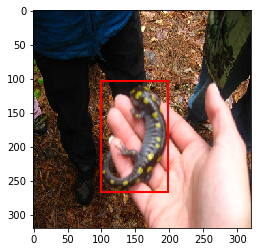

[0.   0.   0.   1.   0.   0.   0.   0.   0.36 0.45 0.72 0.71]


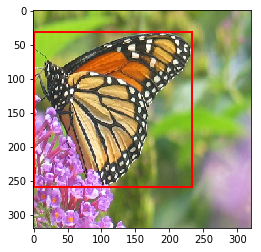

In [12]:
plot_batch(train_generator_multiple_outputs, count=10)

# Armamos modelo basado en VGG-16

In [13]:
from keras.applications.vgg16 import VGG16

In [14]:
modelVGG16 = VGG16(include_top=False, weights='imagenet', input_shape=(*target_size, 3))

In [15]:
modelVGG16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 320, 320, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 320, 320, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 320, 320, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 160, 160, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 160, 160, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 160, 160, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 80, 80, 128)       0         
__________

# Agregamos capas Densas

In [16]:
from keras.layers import Dense, Flatten, BatchNormalization, Activation, Dropout
from keras.models import Model

In [17]:
n_classes = len(classes)
flatten_output = Flatten()(modelVGG16.output)
dense_1_output = Activation('relu')(Dense(128, name = 'Dense_1')(flatten_output))

dense_2_output = Activation('relu')(Dense(128, name = 'Dense_2')(dense_1_output))
class_prediction = Dense(n_classes, activation='softmax', name='category_output')(dense_2_output)
bbox_prediction = Dense(4, name='bounding_box')(Dropout(0.5)(dense_2_output))
model = Model(inputs=modelVGG16.input, outputs=[class_prediction, bbox_prediction])

In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 320, 320, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 320, 320, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 160, 160, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

# Seteo capas entrenable

In [19]:
N_trainable = 17
print('primer capa entrenable:', model.layers[17].name)

for layer in model.layers[:N_trainable]:
    layer.trainable = False
for layer in model.layers[N_trainable:]:
    layer.trainable = True

primer capa entrenable: block5_conv3


In [20]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 320, 320, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 320, 320, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 160, 160, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

# Metricas y función de Costo

<img src="idea-basica-obj-loc.png" alt="drawing" width="600"/>

# $L = \beta L_{categorical} + \gamma L_{boundingbox}$

# IoU (Intersección Over Union) o Indice de Jaccard

Ratio entre la union de las bounding boxes y la intersección

In [24]:
from custom_losses import IOU_loss, iou, set_classes

In [26]:
set_classes(n_classes)

In [27]:
losses = {"category_output": "categorical_crossentropy", 
          "bounding_box": "mean_squared_error"
          #"bounding_box": IOU_loss
         }
metrics = {"category_output": "accuracy", 
           "bounding_box": [iou, IOU_loss]
          }
lossWeights = {"category_output": 1.0, 
               "bounding_box":  20.0,
              }

In [28]:
train_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_train, 
                                                            train_folder, 50, classes = classes,
                                                            concat_output = False,
                                                            flip = 'random',
                                                            target_size=target_size
                                                           )
val_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_val, 
                                                              val_folder, 50, classes = classes,
                                                              concat_output = False,
                                                              flip = 'random',
                                                          target_size=target_size
                                                         )

Found 2400 images belonging to 8 classes.
Found 480 images belonging to 8 classes.


In [29]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, rmsprop, SGD
filename = 'runtime'
checkpoint = ModelCheckpoint(filepath = filename+'_best.hdf5', 
                             monitor='bounding_box_IOU_loss', save_best_only=True)
model.compile(loss=losses,
              optimizer=Adam(lr=0.001),
              metrics=metrics,
              loss_weights = lossWeights)

In [30]:
from object_detection_helper import PlotLosses

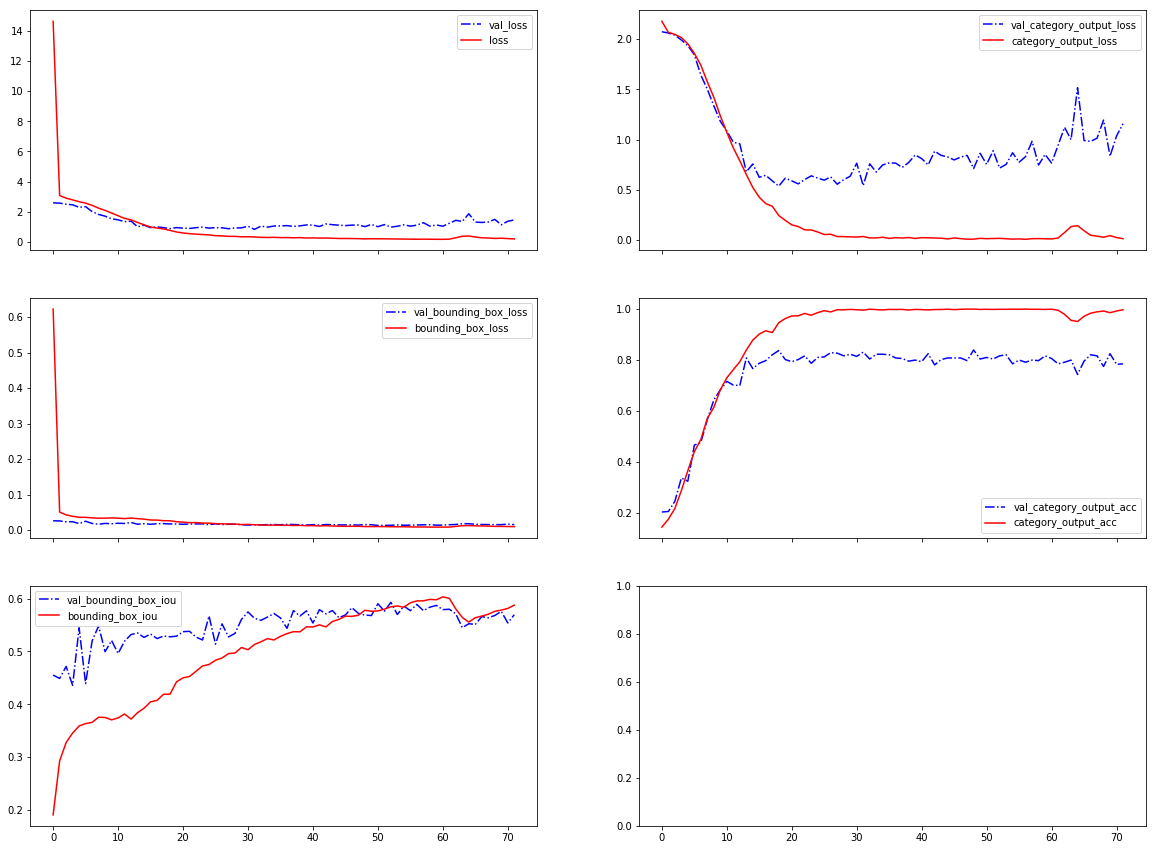

Epoch 73/200
11/48 [=====>........................] - ETA: 9s - loss: 0.2114 - category_output_loss: 0.0297 - bounding_box_loss: 0.0091 - category_output_acc: 0.9945 - bounding_box_iou: 0.5886 - bounding_box_IOU_loss: 0.4114 

KeyboardInterrupt: 

In [31]:
plot_losses = PlotLosses(1)
model.fit_generator(
        train_generator_multiple_outputs,
        #steps_per_epoch=steps_per_epoch,
        epochs=200,
        validation_data=val_generator_multiple_outputs, callbacks = [plot_losses, checkpoint]
        )

In [67]:
model.load_weights('runtime_best.hdf5')

In [68]:
model.evaluate_generator(val_generator_multiple_outputs)

[0.5206253528594971,
 0.23535535112023354,
 0.01426350064575672,
 0.9320000052452088,
 0.6073484897613526,
 0.3926515161991119]

Class OK: 0
IOU: [0.45782152]


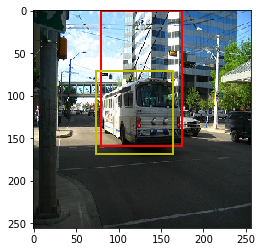

Class OK: 2
IOU: [0.75937209]


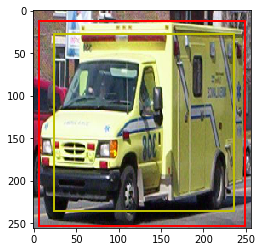

Class OK: 2
IOU: [0.8395914]


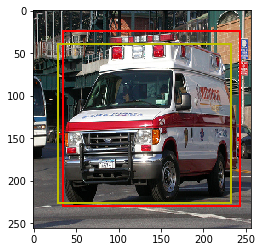

Class OK: 0
IOU: [0.66682165]


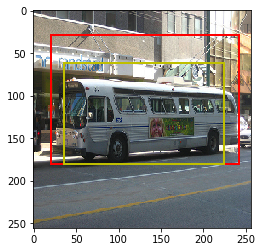

Class OK: 1
IOU: [0.7961611]


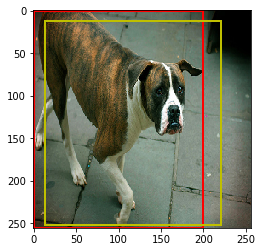

Class OK: 1
IOU: [0.76364523]


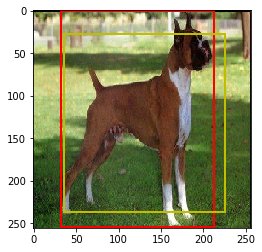

Class OK: 2
IOU: [0.3583412]


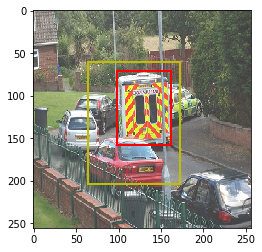

Class OK: 1
IOU: [0.50485234]


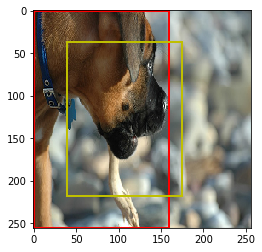

Class OK: 0
IOU: [0.6228829]


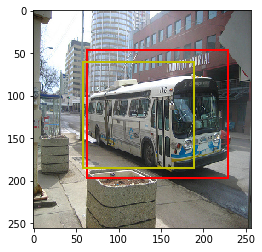

Class OK: 1
IOU: [0.52444714]


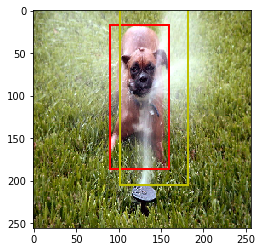

In [70]:
plot_batch(val_generator_multiple_outputs, model, count=10)